# TFM - Evaluación de la calidad del dato - EvaluadorTFM.ipynb

### Datos del autor
Notebook elaborado por: **César Fernando Balaguer García** y **Antonio Luís Almira Martínez** en el marco de la tesis de Máster Universitario en **Análisis y Visualización de Datos Masivos / Visual Analytic y Big Data** (2025) <br>.
Asesora de tesis: **María Belén Benalcázar Tovar**. <br>
Título: **Marco Metodológico que permita medir la calidad de los datos de un conjunto de datos en formatos planos**.

## 1. Preparación del entorno
En este punto se realiza la carga de las librerías y funciones necesarias para la evaluación de la calidad de los datos, 

### 1.1 Carga las librerías necesarias para la evaluación

In [1]:
#!pip install squarify

In [2]:
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re

from IPython.display import display, clear_output
from matplotlib.backends.backend_pdf import PdfPages
from math import pi


Carga la librería principal para la medición de la calidad de un conjunto de datos (Elaboración propia)

In [3]:
import FuncionesTFM as tfm
importlib.reload(tfm)
clear_output(wait=True)

### 1.2 Funciones varias
En esta sección definimos funciones básicas que se usarán a lo largo de la medición de la calidad, son rutinas de apoyo que serviran entre otras cosas para imprimir los resultados finales de la medición de la calidad del conjunto de datos o la impresión de los títulos para cada sección

Función que imprime los títulos de todas las secciones donde se van a mostra resultados

In [4]:
def imprimir_titulo(texto):
    print(f"\033[1m\033[4m{texto}\033[0m")  # Negrita + subrayado


Función de impresión de resultados de la evalción del conjunto de datos

In [5]:
def imprimir_resultado(icono, campo, dimension, calidad, umbral_minimo, umbral_aceptable, mensaje):
    # Si 'campo' es lista, la unimos en un string
    if isinstance(campo, list):
        campo = ", ".join(campo)

    # Anchos fijos para cada columna
    ancho_icono        = 2
    ancho_campo        = 25
    ancho_dimension    = 15
    ancho_calidad      = 10
    ancho_umbral_min   = 13
    ancho_umbral_acp   = 14
    
    print(
        f"{icono:<{ancho_icono}}  "
        f"{campo:<{ancho_campo}} | "
        f"{dimension:<{ancho_dimension}} | "
        f"{calidad:>{ancho_calidad}.2f}% | "
        f"{umbral_minimo:>{ancho_umbral_min}.2f}% | "
        f"{umbral_aceptable:>{ancho_umbral_acp}.2f}% | "
        f"{mensaje}"
    )


Función que permite imprimir la parametría realizada

In [6]:
def imprimir_parametria(configuraciones):
    imprimir_titulo("Configuraciones registradas")
    print("")
    print(f"{'Encabezado':<25} {'Dimensión':<15} {'Validador':<25} {'Umbral Min':<10} {'Umbral Acep':<10}")
    print("-" * 90)

    for config in configuraciones:
        encabezado = ", ".join(config['encabezado'])
        print(f"{encabezado:<25} {config['dimension']:<15} {config['validador']:<25} {config['umbral_minimo']:<10} {config['umbral_aceptable']:<10}")
        

In [7]:
def imprimir_resultado_final():
    imprimir_titulo("Medición de la calidad por campo y dimensión")
    print("")
    print(f"{' S   ':<2} {'Campo':<27} {'Dimension':<20} {'Calidad':<14} {'Umbral Min':<15} {'Umbral Acep':<14} {'Resultado':<28}")
    print("-" * 130)
    for r in resultado:
        imprimir_resultado(r["icono"], 
                           r["campo"], 
                           r["dimension"], 
                           r["calidad"],  
                           r["umbral_minimo"], 
                           r["umbral_aceptable"],
                           r["mensaje"])
    print("")

    imprimir_titulo("Medición de la calidad por dimensión")
    print("")
    promedios_dimension = tfm.promedio_calidad_dimensiones(resultado)
    for dimension, promedios_dimension in promedios_dimension.items():
        print(f"Dimensión: {dimension:<12} | Promedio calidad: {promedios_dimension:.2f}%")

    print("")

    imprimir_titulo("Medición de la calidad por campo")
    print("")
    promedios_campos = tfm.promedio_calidad_campos(resultado)
    for campo, promedio_campos in promedios_campos.items():
        print(f"Campo: {campo:<20} | Promedio calidad: {promedio_campos:.2f}%")


## 2. Evaluación del conjunto de datos
En este punto se recorrerá la lista con la configuración realizada en el paso previo y por cada registro existente en la lista se ejecutará el evaluador, para poder lograr esto se va a crear una función por cada dimensión, esta función devolverá el porcentaje de calidad del dato, el resultado de cada una de las dimensiones - datos evaluados se almacenarán en una colección y luego se guardatán en un archivo con formato **CSV** para que pueda ser visualizado desde un archivo Excel o para tener el registro de la evaluación realizada.

### 2.1 Sección de carga y preparación

Deeclaración de variables iniciales:
>- **Dimensiones**: Relación de dimensiones a evaluar (genéricas) basadas en la norma ISO/IEC 25012
>- **Configuraciones**: Lista de configuraciones parametrizadas, recuperadas del archivo .conf
>  

In [8]:
dimensiones = [
    "Exactitud",
    "Completitud",
    "Consistencia",
    "Credibilidad",
    "Unicidad"
]
configuraciones = []
nombre_archivo = ""

Carga de los archivos necesrios para la evaluación de la calidad de datos:
>- **archivo_data**: conjunto de datos a evaluar, el archivo se dene encontrar en formato csv.
>- **archivo_parametro**: archivo de configuración registrado previamente.
>

In [9]:
nombre_archivo = input("\nIngrese el nombre del archivo de datos a evaluar (sin extensión): ")
archivo_data      = nombre_archivo + ".csv"
archivo_parametro = nombre_archivo + ".conf"

df_data = pd.read_csv(archivo_data, sep=";")
df_parametro = pd.read_csv(archivo_parametro, sep=";", encoding="utf-8")

configuraciones = []
df_parametro['encabezado'] = df_parametro['encabezado'].apply(ast.literal_eval)
configuraciones = df_parametro.to_dict(orient="records")

encabezados = list(df_data.columns)

clear_output(wait=True)
imprimir_titulo("Conjunto de datos y nombre de campos a evaluar")
print("")
print(archivo_data)
print(encabezados)
print("")
imprimir_parametria(configuraciones)

Conjunto de datos y nombre de campos a evaluar

dataset.csv
['CONTENIDO A ANALIZAR', 'INTENSIDAD']

Configuraciones registradas

Encabezado                Dimensión       Validador                 Umbral Min Umbral Acep
------------------------------------------------------------------------------------------
CONTENIDO A ANALIZAR      Completitud                               100.0      100.0     
CONTENIDO A ANALIZAR      Unicidad                                  100.0      100.0     
INTENSIDAD                Completitud                               100.0      100.0     
INTENSIDAD                Credibilidad    1, 2, 3, 4                98.0       99.0      
INTENSIDAD                Consistencia    9                         98.0       99.0      
INTENSIDAD                Exactitud       1:4                       98.0       99.0      


### 2.2 Sección principal
En esta sección se recorre la colección de configuración y por cada registro llama a la función correspondiente para la dimensión requerida por validar, finalmente el resultado de cada fila recorrida será almacenada en una colección "**resultado**" donde se tendrán los siguientes datos:
>- Campo: Nombre del campo o columna del dataset que se evalúa
>- Dimensión: Nombre de la dimensión de la calidad o característica del dato que es evaluada
>- Umbral mínimo: Porcentaje mínimo requerido para que el dato pueda considerarse aceptable
>- Umbral aceptable: Límite superior considerado para que un dato pueda ser considerado aceptable
>- Calidad: Resultado cuantitativo de la evaluación de la calidad, el resultado obtenido nos dará una evaluación cualitativa de la evaluación de la calidad bajo el siguiente esquema:
>>- Dato no aceptado: El dato se considera como no aceptado cuando el resultado cuantitativo de la calidad se encuentra por debajo del umbral mínimo de aceptación
>>- Dato aceptable: Se considera un dato aceptable cuando el valor cuantitativo de la calidad se encuentra enmarcado entre el umbral mínimo y el umbral aceptable
>>- Dato con calidad demostrada: Se considera un dato con calidad demostrada cuando el valor cuantitativo de la calidad es mayor o igual al umbral aceptable.

In [10]:
funciones_dimensiones = {
    "Exactitud": tfm.exactitud,
    "Completitud": tfm.completitud,
    "Consistencia": tfm.consistencia,
    "Credibilidad": tfm.credibilidad,
    "Unicidad": tfm.unicidad
}

resultado = []

display("⏳ Procesando...")

for config in configuraciones:
    nombre_dim = config['dimension']
    funcion = funciones_dimensiones.get(nombre_dim)

    if funcion:
        resultado_dim = funcion(
            df_data,
            config['encabezado'],
            config['validador'],
            config['umbral_minimo'],
            config['umbral_aceptable']
        )
        resultado.append(resultado_dim)

clear_output(wait=True)
imprimir_resultado_final()


Medición de la calidad por campo y dimensión

 S    Campo                       Dimension            Calidad        Umbral Min      Umbral Acep    Resultado                   
----------------------------------------------------------------------------------------------------------------------------------
🟢   CONTENIDO A ANALIZAR      | Completitud     |     100.00% |        100.00% |         100.00% | cumple el umbral aceptable
🔴   CONTENIDO A ANALIZAR      | Unicidad        |      91.12% |        100.00% |         100.00% | Debajo del umbral mínimo
🟢   INTENSIDAD                | Completitud     |     100.00% |        100.00% |         100.00% | cumple el umbral aceptable
🟡   INTENSIDAD                | Credibilidad    |      98.29% |         98.00% |          99.00% | Debajo del umbral aceptable
🟢   INTENSIDAD                | Consistencia    |     100.00% |         98.00% |          99.00% | Cumple el umbral aceptable
🟡   INTENSIDAD                | Exactitud       |      98.29% | 

### 2.3 Sección de generación de informe gráfico (Dashboard)
Luego de evaluar la calidad de los datos del dataset y mostrar una tabla semaforizada con los valores de calidad y lso umbrales definidos, el siguiente paso es mostrar una serie de gráficos que ayuden a visualizar de una manera mas sencilla y gráfica el resultado a cerca de la calidad del dato, para ello se han elegido los siguientes diagramas:
>- Mapa de calor por dato y dimensión
>- Gráfico de burbuja por dato y dimensión
>- Diagrama de radar por conjunto de datos
>- Diagrama de dona por conjunto de datos

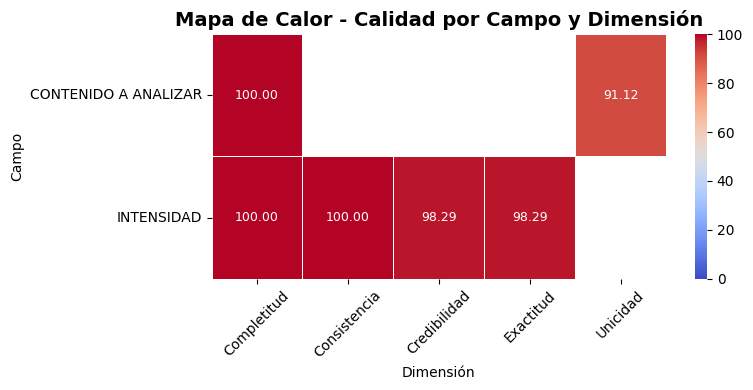

In [11]:
df_resultado = pd.DataFrame(resultado)
df_resultado["campo"] = df_resultado["campo"].apply(lambda x: ", ".join(x) if isinstance(x, list) else str(x))

heatmap_data = df_resultado.pivot_table(
    index="campo",
    columns="dimension",
    values="calidad",
    aggfunc="mean"
)

plt.figure(figsize=(8, 4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True,
    square=False,
    annot_kws={"fontsize":9},
    vmin=0,          # 👈 Valor mínimo fijo en 0
    vmax=100         # 👈 Valor máximo fijo en 100
)

plt.title("Mapa de Calor - Calidad por Campo y Dimensión", fontsize=14, weight="bold")
plt.xlabel("Dimensión", fontsize=10)
plt.ylabel("Campo", fontsize=10)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


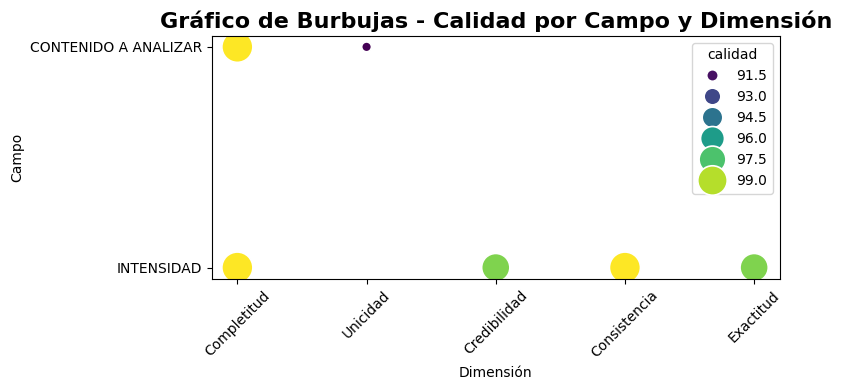

In [12]:
df_resultado = pd.DataFrame(resultado)
df_resultado['campo_str'] = df_resultado['campo'].apply(lambda x: ", ".join(x) if isinstance(x, list) else str(x))

plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_resultado,
    x="dimension",
    y="campo_str",
    size="calidad",
    hue="calidad",
    palette="viridis",
    sizes=(50, 500),
    legend="brief"
)

plt.title("Gráfico de Burbujas - Calidad por Campo y Dimensión", fontsize=16, weight="bold")
plt.xlabel("Dimensión", fontsize=10)
plt.ylabel("Campo", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



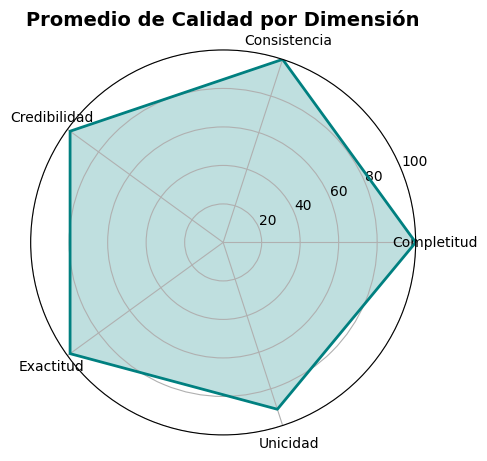

In [13]:
df_resultado = pd.DataFrame(resultado)
promedios = df_resultado.groupby("dimension")["calidad"].mean()

labels = list(promedios.index)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values = promedios.tolist()
values += values[:1]  # cerrar el círculo
angles += angles[:1]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='teal', linewidth=2)
ax.fill(angles, values, color='teal', alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Promedio de Calidad por Dimensión", fontsize=14, weight="bold")
ax.set_ylim(0, 100)
plt.show()


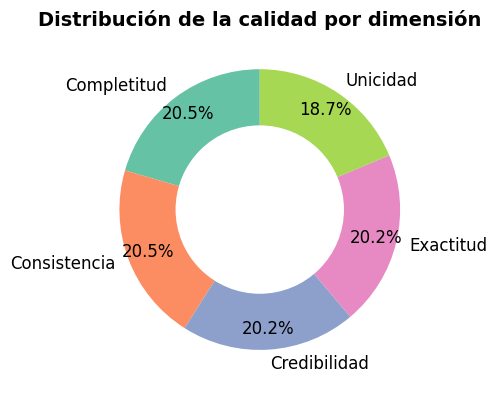

In [20]:
df_resultado = pd.DataFrame(resultado)

# Obtener el promedio de calidad por dimensión
promedios = df_resultado.groupby("dimension")["calidad"].mean().reset_index()

# Configurar gráfico de dona
fig, ax = plt.subplots(figsize=(5, 5))

colores = plt.cm.Set2.colors  # Paleta agradable de colores
wedges, texts, autotexts = ax.pie(
    promedios["calidad"],
    labels=promedios["dimension"],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colores,
    textprops={'fontsize': 12}
)

# Añadir círculo central para hacer "dona"
centro = plt.Circle((0,0), 0.60, fc='white')
fig.gca().add_artist(centro)

# Título del gráfico
ax.set_title("Distribución de la calidad por dimensión", fontsize=14, weight="bold")

plt.tight_layout()
plt.show()


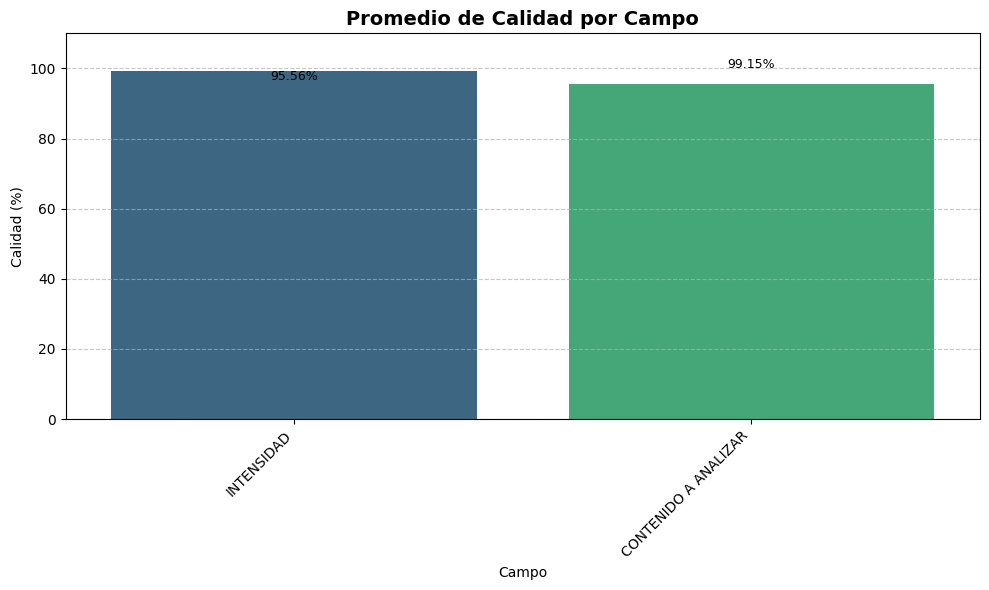

In [34]:
df_resultado = pd.DataFrame(resultado)

# Convertir 'campo' a string si es lista
df_resultado["campo"] = df_resultado["campo"].apply(lambda x: ", ".join(x) if isinstance(x, list) else str(x))

# Obtener el promedio de calidad por campo
promedios = df_resultado.groupby("campo")["calidad"].mean().reset_index()
promedios = promedios.sort_values(by="calidad", ascending=False)

plt.figure(figsize=(10, 6))
barras = sns.barplot(
    data=promedios, 
    x="campo", 
    y="calidad", 
    hue="campo", 
    palette="viridis", 
    legend=False 
)

# Mostrar porcentaje encima de cada barra
for i, row in promedios.iterrows():
    barras.text(
        i, row.calidad + 1, f"{row.calidad:.2f}%",
        color='black', ha='center', fontsize=9
    )

plt.title("Promedio de Calidad por Campo", fontsize=14, weight="bold")
plt.xlabel("Campo", fontsize=10)
plt.ylabel("Calidad (%)", fontsize=10)
plt.ylim(0, 110)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



## 3. Informe final
El evaluador de la calidad de los datos genera un informe final, donde se muestra la siguiente información:
>- Tabla de resultados incluida la semaforización de la calidad de los datos
>- Graficos de apoyo
>>- Diagrama de radar
>>- Diagrama de dona
>>- Diagrama de burbuja
>>
>
Sobre estos diagramas se pueden añadir otros más como soporte a los ya mostrados.

In [35]:
def obtener_semaforo(calidad, umbral_minimo, umbral_aceptable):
    if calidad >= umbral_aceptable:
        return '●', 'green'
    elif calidad >= umbral_minimo:
        return '●', 'yellow'
    else:
        return '●', 'red'

def generar_pdf_completo(df_resultado, nombre_archivo):
    with PdfPages(nombre_archivo + ".pdf") as pdf:
        fig = plt.figure(figsize=(14, 10))

        # SUBPLOT 1 - Tabla con semáforo
        ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=4)
        ax1.axis('off')

        columnas = list(df_resultado.columns)
        col_index = columnas.index("icono")
        tabla = ax1.table(
            cellText=df_resultado.values,
            colLabels=columnas,
            cellLoc='center',
            loc='center'
        )
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(9)
        tabla.scale(1, 1.5)

        for i in range(len(df_resultado)):
            simbolo, color = obtener_semaforo(df_resultado.iloc[i]['calidad'], df_resultado.iloc[i]['umbral_minimo'], df_resultado.iloc[i]['umbral_aceptable'])
            tabla[i+1, col_index].get_text().set_text(simbolo)
            tabla[i+1, col_index].get_text().set_color(color)

        ax1.set_title("Resultados de Calidad", fontsize=14, weight='bold')
      
        # SUBPLOT 2 - Radar
        ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=2, rowspan=2, polar=True)
        promedio = df_resultado.groupby('dimension')['calidad'].mean()
        categorias = promedio.index.tolist()
        valores = promedio.values.tolist() + [promedio.values[0]]
        angulos = [n / float(len(categorias)) * 2 * pi for n in range(len(categorias))] + [0]
        ax2.plot(angulos, valores, linewidth=2, linestyle='solid')
        ax2.fill(angulos, valores, alpha=0.3)
        ax2.set_theta_offset(pi / 2)
        ax2.set_theta_direction(-1)
        ax2.set_xticks(angulos[:-1])
        ax2.set_xticklabels(categorias)
        ax2.set_yticks([20, 40, 60, 80, 100])
        ax2.set_ylim(0, 100)
        ax2.set_title("Gráfico Radar", fontsize=10)
   
        # SUBPLOT 3 - Dona
        ax3 = plt.subplot2grid((3, 4), (1, 2), colspan=2)
        wedges, texts, autotexts = ax3.pie(
            promedio, labels=promedio.index, autopct='%1.1f%%',
            startangle=140, pctdistance=0.85
        )
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig.gca().add_artist(centre_circle)
        ax3.axis('equal')
        ax3.set_title("Gráfico Dona", fontsize=10)

        # SUBPLOT 4 - Burbuja
        ax4 = plt.subplot2grid((3, 4), (2, 2), colspan=2)
        burbuja = df_resultado.copy()
        burbuja["campo"] = burbuja["campo"].apply(lambda x: ", ".join(x) if isinstance(x, list) else str(x))
        x = range(len(burbuja))
        y = burbuja["calidad"]
        sizes = burbuja["calidad"] * 5
        colors = burbuja["calidad"]
        ax4.scatter(x, y, s=sizes, c=colors, cmap="coolwarm", alpha=0.6, edgecolors="black")
        ax4.set_xticks(x)
        ax4.set_xticklabels(burbuja["campo"], rotation=45, ha='right')
        ax4.set_ylim(0, 110)
        ax4.set_ylabel("Calidad (%)")
        ax4.set_title("Gráfico de Burbujas", fontsize=10)
        ax4.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close()

    print("✅ PDF generado correctamente")


In [16]:
df_resultado = pd.DataFrame(resultado)
nombre_pdf = nombre_archivo + ".pdf"
generar_pdf_completo(df_resultado,nombre_pdf)

✅ PDF generado correctamente
